In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

%matplotlib inline

In [71]:
# Load the dataset
df = pd.read_excel('/content/sample_data/german_credit_data.xlsx')

In [41]:
# Display the first 5 rows of the dataframe
print(df.head())

   Age     Sex  Job Housing Saving accounts Checking account  Credit amount  \
0   67    male    2     own             NaN           little           1169   
1   22  female    2     own          little         moderate           5951   
2   49    male    1     own          little              NaN           2096   
3   45    male    2    free          little           little           7882   
4   53    male    2    free          little           little           4870   

   Duration              Purpose  Risk  
0         6             radio/TV  good  
1        48             radio/TV   bad  
2        12            education  good  
3        42  furniture/equipment  good  
4        24                  car   bad  


In [72]:
# Check the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB
None


In [6]:
# Check for missing values
print(df.isnull().sum())

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [7]:
# Check for duplicates
print(df.duplicated().sum())

0


In [8]:
# Explore the distribution of each feature
print(df.describe())

               Age          Job  Credit amount     Duration
count  1000.000000  1000.000000    1000.000000  1000.000000
mean     35.546000     1.904000    3271.258000    20.903000
std      11.375469     0.653614    2822.736876    12.058814
min      19.000000     0.000000     250.000000     4.000000
25%      27.000000     2.000000    1365.500000    12.000000
50%      33.000000     2.000000    2319.500000    18.000000
75%      42.000000     2.000000    3972.250000    24.000000
max      75.000000     3.000000   18424.000000    72.000000


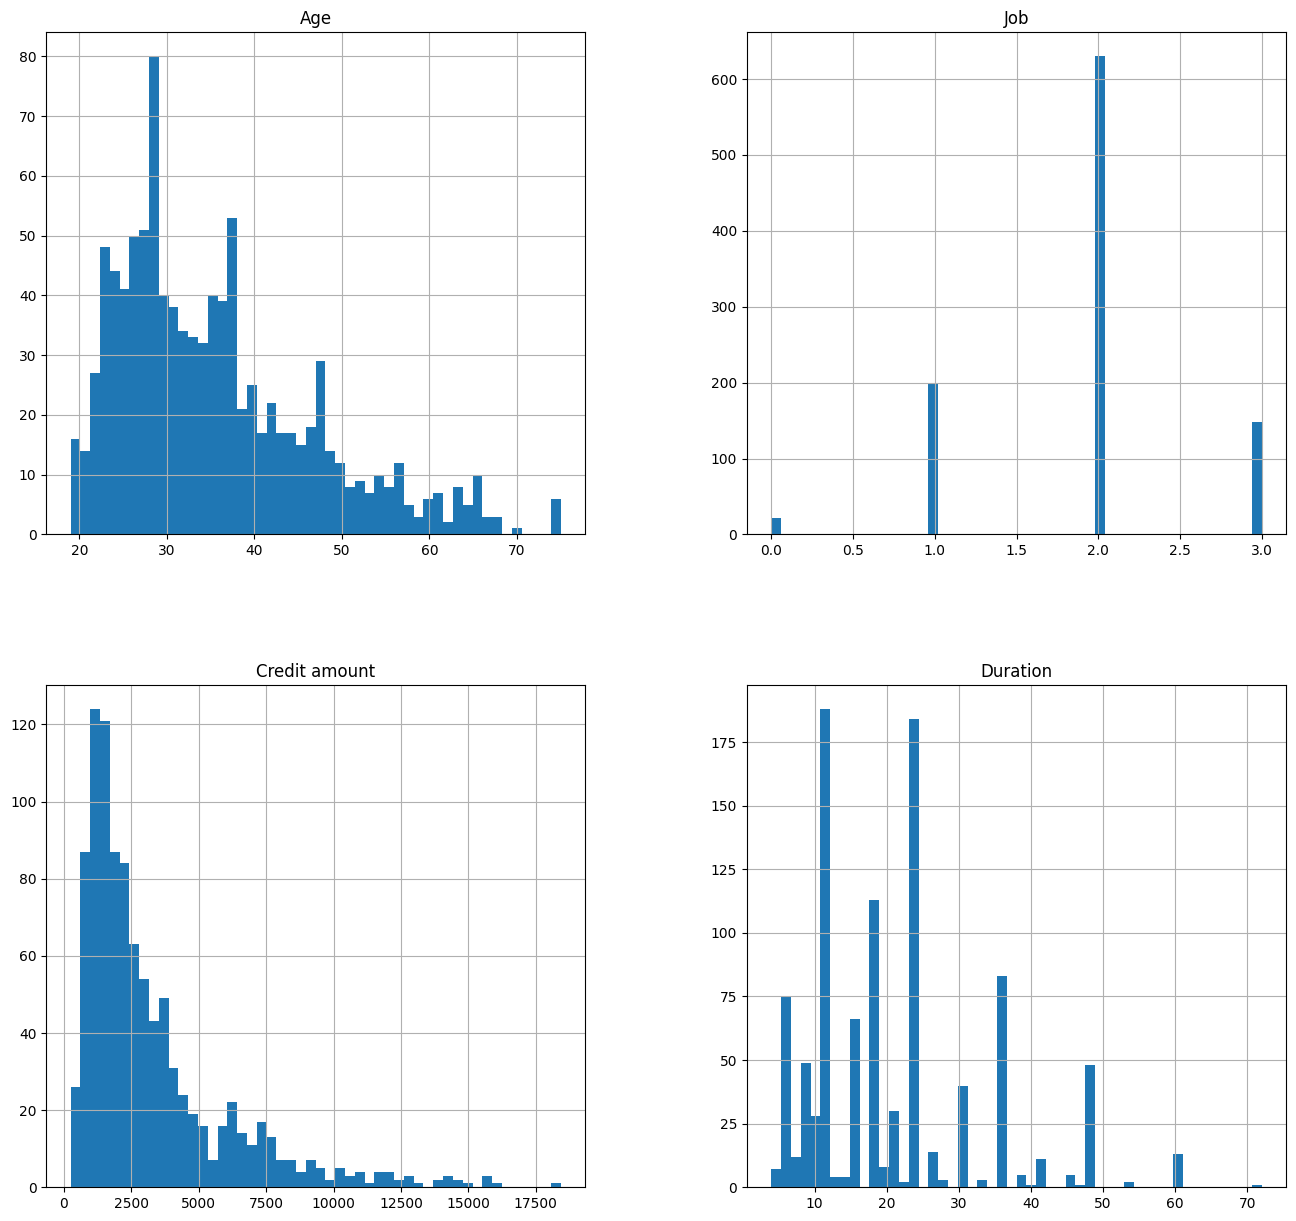

In [42]:
# Visualize the distribution of each feature using histograms
df.hist(bins=50, figsize=(16,15))
plt.show()

In [84]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop missing values
df.dropna(inplace=True)

In [74]:
# Check the structure of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 1 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               522 non-null    int64 
 1   Sex               522 non-null    object
 2   Job               522 non-null    int64 
 3   Housing           522 non-null    object
 4   Saving accounts   522 non-null    object
 5   Checking account  522 non-null    object
 6   Credit amount     522 non-null    int64 
 7   Duration          522 non-null    int64 
 8   Purpose           522 non-null    object
 9   Risk              522 non-null    object
dtypes: int64(4), object(6)
memory usage: 44.9+ KB
None


In [75]:
# Select categorical columns
cat_cols = ['Sex', 'Housing', 'Checking account', 'Saving accounts', 'Purpose']

# Create an instance of the OneHotEncoder class
ohe = OneHotEncoder()

# Fit and transform the categorical columns
cat_data = ohe.fit_transform(df[cat_cols])

df_encoded = pd.DataFrame(cat_data.toarray())

# Rename the columns with the feature names
new_col_names = []
for i, col in enumerate(cat_cols):
    unique_cats = df[col].unique()
    for cat in unique_cats:
        new_col_names.append(f"{col}_{cat}")
df_encoded.columns = new_col_names

df = pd.concat([df, df_encoded], axis=1)
df.drop(cat_cols, axis=1, inplace=True)

In [76]:
df.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Risk', 'Sex_female',
       'Sex_male', 'Housing_own', 'Housing_free', 'Housing_rent',
       'Checking account_moderate', 'Checking account_little',
       'Checking account_rich', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Purpose_radio/TV',
       'Purpose_furniture/equipment', 'Purpose_car', 'Purpose_business',
       'Purpose_domestic appliances', 'Purpose_repairs',
       'Purpose_vacation/others', 'Purpose_education'],
      dtype='object')

In [77]:
df.head()

,Age,Job,Credit amount,Duration,Risk,Sex_female,Sex_male,Housing_own,Housing_free,Housing_rent,...,Saving accounts_quite rich,Saving accounts_rich,Purpose_radio/TV,Purpose_furniture/equipment,Purpose_car,Purpose_business,Purpose_domestic appliances,Purpose_repairs,Purpose_vacation/others,Purpose_education
1,22.0,2.0,5951.0,48.0,bad,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,45.0,2.0,7882.0,42.0,good,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,53.0,2.0,4870.0,24.0,bad,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,35.0,3.0,6948.0,36.0,good,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,28.0,3.0,5234.0,30.0,bad,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Age 0.5378729428729064
Job 0.4709523138806196
Credit amount 0.027170236262108877
Duration 0.0047827535884948785


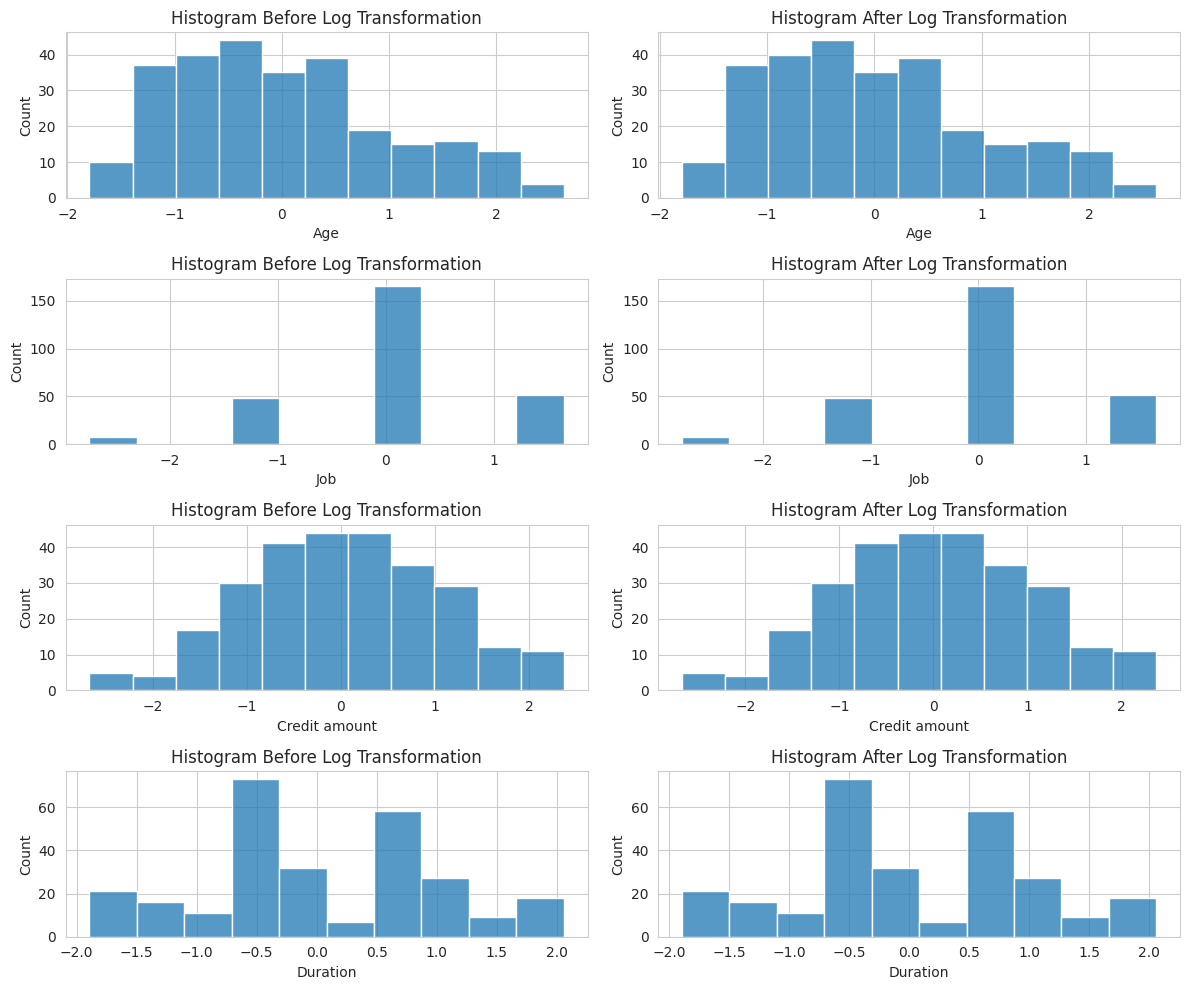

In [107]:
# Select the numerical features
num_features = ['Age', 'Job', 'Credit amount', 'Duration']

# Create a 2 column layout for the plots
fig, axes = plt.subplots(nrows=len(num_features), ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(num_features):
    # Plot the histogram before log transformation
    sns.histplot(ax=axes[2*i], data=df, x=col)
    axes[2*i].set_xlabel(col)
    axes[2*i].set_ylabel('Count')
    axes[2*i].set_title('Histogram Before Log Transformation')
    
    # Check for skewness in the data
    skewness = np.abs(df[col].skew())
    print(col, skewness)
    if skewness > 1:
        # Apply log transformation
        print("applying log transformation for", col)
        df[col] = np.log(df[col])
    
    # Plot the histogram after log transformation
    sns.histplot(ax=axes[2*i+1], data=df, x=col)
    axes[2*i+1].set_xlabel(col)
    axes[2*i+1].set_ylabel('Count')
    axes[2*i+1].set_title('Histogram After Log Transformation')
    
# Adjust the layout
plt.tight_layout()
plt.show()

1. Observations:

- Age and Job have moderate positive skewness, which means that the majority of data is concentrated on the lower end of the range and there are some extreme values towards the higher end of the range.
- Credit amount and Duration have very low skewness values, which means that the distribution of data is relatively symmetric.

2. Analysis and Reasoning:
- The moderate positive skewness of Age and Job may be due to the fact that the dataset contains mostly young people with relatively low job skills, and relatively few highly skilled and older people. This can result in a concentration of data towards the lower end of the range for these features.
- Credit amount and Duration are loan-related features, and it is not surprising to see that they have relatively symmetric distributions, as loans are typically offered in a structured and standardized manner, and the amount and duration are subject to certain rules and limitations.

In [79]:
# Define the numerical features
numerical_cols = ['Age', 'Job', 'Credit amount', 'Duration']

# Apply feature scaling to the numerical features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Print the first 5 rows of the scaled dataset
print(df.head())

        Age      Job  Credit amount  Duration  Risk  Sex_female  Sex_male  \
1 -1.322038  0.18254       1.144141  1.674998   bad         0.0       1.0   
3  0.982558  0.18254       1.493595  1.445881  good         0.0       1.0   
4  1.509513  0.18254       0.894862  0.485676   bad         0.0       1.0   
7  0.173220  1.64848       1.336754  1.181384  good         1.0       0.0   
9 -0.545395  1.64848       0.984496  0.868552   bad         1.0       0.0   

   Housing_own  Housing_free  Housing_rent  ...  Saving accounts_quite rich  \
1          1.0           0.0           0.0  ...                         0.0   
3          0.0           0.0           1.0  ...                         0.0   
4          0.0           1.0           0.0  ...                         0.0   
7          0.0           1.0           0.0  ...                         0.0   
9          0.0           0.0           1.0  ...                         0.0   

   Saving accounts_rich  Purpose_radio/TV  Purpose_furniture/e

In [80]:
numerical_cols = ['Age', 'Job', 'Credit amount', 'Duration']

# Select only the numerical features
df_numerical = df[numerical_cols]

# Print the first 5 rows of the numerical dataset
print(df_numerical.head())

        Age      Job  Credit amount  Duration
1 -1.322038  0.18254       1.144141  1.674998
3  0.982558  0.18254       1.493595  1.445881
4  1.509513  0.18254       0.894862  0.485676
7  0.173220  1.64848       1.336754  1.181384
9 -0.545395  1.64848       0.984496  0.868552


In [86]:
# Drop missing values
df_numerical.dropna(inplace=True)
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522 entries, 1 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            522 non-null    float64
 1   Job            522 non-null    float64
 2   Credit amount  522 non-null    float64
 3   Duration       522 non-null    float64
dtypes: float64(4)
memory usage: 20.4 KB


<ipython-input-86-6861836dc4fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical.dropna(inplace=True)


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

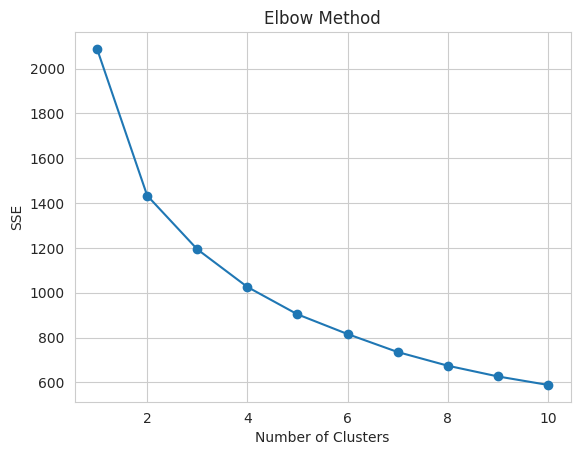

In [87]:
# Apply the elbow method to find the best number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_numerical)
    sse.append(kmeans.inertia_)

# Plot the elbow curve using Seaborn
sns.set_style("whitegrid")
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

The optimal number of clusters is usually the "elbow point" on the curve, where the rate of decrease in inertia starts to slow down. In this case, it looks like the elbow point is around 2 or 3 clusters, but it's not very clear.

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-89-c2a73fc95cc8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numerical['Cluster'] = kmeans.fit_predict(df_numerical)


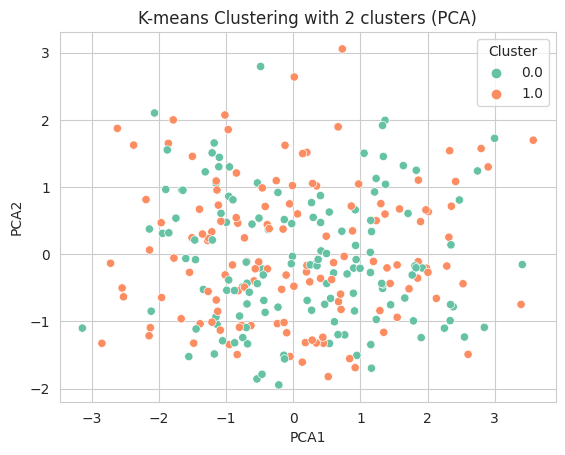

In [89]:
# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=2, random_state=42)
df_numerical['Cluster'] = kmeans.fit_predict(df_numerical)

# Visualize the clusters using PCA
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_numerical.drop('Cluster', axis=1)), columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = df_numerical['Cluster']
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('K-means Clustering with 2 clusters (PCA)')
plt.show()

In [105]:
# Define the features and target variable
X = df.drop('Risk', axis=1)
y = df['Risk']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Define the K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the classifier using K-Fold Cross Validation
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for train_idx, val_idx in kf.split(X_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # Fit the classifier to the training data
    rfc.fit(X_train_fold, y_train_fold)
    
    # Predict on the validation data and evaluate the metrics
    y_pred_fold = rfc.predict(X_val_fold)
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred_fold))
    precision_scores.append(precision_score(y_val_fold, y_pred_fold, pos_label="good"))
    recall_scores.append(recall_score(y_val_fold, y_pred_fold, pos_label="good"))
    f1_scores.append(f1_score(y_val_fold, y_pred_fold, pos_label="good"))

# Calculate the mean and standard deviation of the evaluation metrics
accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)
accuracy_std = np.std(accuracy_scores)

precision_mean = sum(precision_scores) / len(precision_scores)
precision_std = np.std(precision_scores)

recall_mean = sum(recall_scores) / len(recall_scores)
recall_std = np.std(recall_scores)

f1_mean = sum(f1_scores) / len(f1_scores)
f1_std = np.std(f1_scores)

# Print the evaluation metrics
print('Accuracy: {:.2f} +/- {:.2f}'.format(accuracy_mean, accuracy_std))
print('Precision: {:.2f} +/- {:.2f}'.format(precision_mean, precision_std))
print('Recall: {:.2f} +/- {:.2f}'.format(recall_mean, recall_std))
print('F1-Score: {:.2f} +/- {:.2f}'.format(f1_mean, f1_std))


Accuracy: 0.54 +/- 0.05
Precision: 0.59 +/- 0.07
Recall: 0.70 +/- 0.08
F1-Score: 0.64 +/- 0.07


Accuracy: 0.54 +/- 0.05 means that on average, the classifier correctly classified 54% of the samples in the test set. The +/- 0.05 indicates the variance of the accuracy score across the different folds.

Precision: 0.59 +/- 0.07 means that on average, when the classifier predicted a sample to be "good" risk, it was correct 59% of the time. The +/- 0.07 indicates the variance of the precision score across the different folds.

Recall: 0.70 +/- 0.08 means that on average, the classifier correctly identified 70% of the "good" risk samples in the test set. The +/- 0.08 indicates the variance of the recall score across the different folds.

F1-Score: 0.64 +/- 0.07 is the harmonic mean of precision and recall, and it indicates the overall performance of the classifier. On average, the F1-score was 64% in the test set. The +/- 0.07 indicates the variance of the F1-score across the different folds.

Overall, these metrics suggest that the classifier has moderate performance in identifying "good" credit risk applicants. However, the relatively high variance across the different folds suggests that the performance may not be consistent across different subsets of the data, and further optimization may be necessary to improve the model's performance
